# 라이브러리 및 데이터

In [3]:
# 패키지 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [4]:
# 데이터 불러오기
df = pd.read_csv("raw/funda.csv")

In [3]:
# 데이터 확인
df.shape

(2318410, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318410 entries, 0 to 2318409
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 159.2+ MB


# 데이터 전처리
* 날짜 관련 컬럼 추가   
  * year(연), month(월), dayofweek(요일)

In [6]:
# transcated_date컬럼 날짜형으로 변경
df["transacted_date"] = pd.to_datetime(df["transacted_date"])

# year컬럼추가
df["year"] = df["transacted_date"].dt.year

# month컬럼추가
df["month"] = df["transacted_date"].dt.month

# dayofweek컬럼추가
df["dayofweek"] = df["transacted_date"].dt.dayofweek

* 공휴일 관련 컬럼 추가
    * holidays (휴일은 1, 평일은 0)

In [7]:
# 특일정보 api 
import requests
import urllib.request 
import json 
from pandas.io.json import json_normalize 

year_list =[2016,2017,2018,2019]
hd = pd.DataFrame()

for year in year_list:
    url=f"http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear={year}&ServiceKey=hVs%2FiLM%2BMiy0lSUle2QqWQHQUawxBZxASc3Df%2Br7L%2FHSeqz7J8kCbFpCmsMrUVmLn%2F4dDPA%2BEqaI%2F%2BEm351Jzg%3D%3D&_type=json"

    response = urllib.request.urlopen(url) 
    json_str = response.read().decode("utf-8")
    json_object = json.loads(json_str)
    hd_temp=pd.json_normalize(json_object['response']['body'])['items.item'][0]
    hd=hd.append(hd_temp)

In [ ]:
# for문 사용해 holidays 컬럼추가
hd['locdate'] = pd.to_datetime(hd['locdate'])
hd_list = hd['locdate'].tolist()

for i in range(len(df)):
    if df['transacted_date'][i] in hd_list :
        df['holidays'][i]=1
    else:
        if df['dayofweek'][i] > 4: #주말일 경우
            df['holidays'][i]=1
        else:
            df['holidays'][i]=0

* 시간 관련 컬럼 추가   
    * hour(시간)

In [85]:
# transacted_time 컬럼 이용해 hour 컬럼추가
a = []
r = range(0,len(df["transacted_time"]))
for i in r :
        a.append(df.loc[i,'transacted_time'].split(':')[0])
        
df["hour"]=a

* 지역 관련 컬럼 추가   
    * sido(광역시 및 도시)

In [ ]:
# region컬럼 이용해 sido 컬럼추가
a = []
r = range(0,6556613)
for i in r :
    if pd.isnull(df.loc[i,'region']) == True :
        a.append(np.nan)
    else :
        a.append(df.loc[i,'region'].split()[0])
df["sido"] = a

* 업종 관련 컬럼 추가   
    * biz : 한국표준산업분류_10차에 근거, 중분류를 기준으로 하는 컬럼 추가

In [ ]:
# 한국표준산업분류표 불러오기
biz=pd.read_excel('data/한국표준산업분류(10차)_표.xlsx')

In [ ]:
# type_of_business컬럼과 한국표준산업분류표 이용해 biz 컬럼추가
for i in tqdm(range(len(df))):
    for j in range(len(biz)):
        if df['type_of_business'][i] == biz['Unnamed: 9'][j]:
            df['biz'][i] = biz['Unnamed: 3'][j]
        elif df['type_of_business'][i] == biz['Unnamed: 7'][j]:
            df['biz'][i] = biz['Unnamed: 3'][j]

## 환불관련 확인
: store id와 card id 기준으로 groupby하여, amount(매출액)의 합이 음수인 경우 삭제

In [59]:
neg = df.groupby(['store_id','card_id'])['amount'].sum().to_frame()
len(neg[neg['amount']<0])

18

In [27]:
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,year,month,dayofweek,hour,sido,holidays,biz
0,8,24386,d,2016-11-23,12:18,0,부산 동래구,한식 음식점업,142,2016,11,2,12,부산,0,음식점 및 주점업
1,8,24386,d,2016-11-23,12:18,0,부산 동래구,한식 음식점업,-142,2016,11,2,12,부산,0,음식점 및 주점업
2,8,24386,d,2016-11-23,12:20,0,부산 동래구,한식 음식점업,143,2016,11,2,12,부산,0,음식점 및 주점업
3,8,24386,d,2016-11-23,12:20,0,부산 동래구,한식 음식점업,-143,2016,11,2,12,부산,0,음식점 및 주점업
4,8,24387,f,2016-11-26,16:03,0,부산 동래구,한식 음식점업,3714,2016,11,5,16,부산,1,음식점 및 주점업


# EDA

* 카드사별 매출 비율은 a>c>b>d>e>f>g 순
* 카드사별 지역 구성 비율은 공통적으로 경기>서울>부산 순
* 업종 구성 비율은 음식점 및 주점업> 소매업> 도매 및 상품 중개업> 교육서비스업> 기타 개인 서비스업 순
* 금요일에 매출 가장 높으며, 일요일에 가장 낮음
* 대체로 명절 연휴에 매출 낮고, 월말(25일 이후)에 매출 높음
* 시간대는 오전10~오후 20시 사이에 거래 활발

<AxesSubplot:ylabel='amount'>

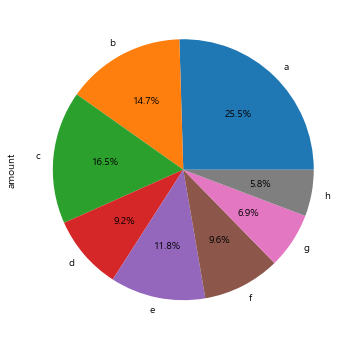

In [7]:
# 카드사별 매출 비율
df.groupby(['card_company'])['amount'].sum().plot.pie(autopct="%.1f%%",figsize=(6,6))

In [17]:
# 날짜별 거래금액
df_sum=df.groupby(['transacted_date'])['amount'].sum().to_frame()
df_sum=df_sum.reset_index()
fig=px.line(df_sum,x='transacted_date', y='amount',title='날짜별 거래금액',template='simple_white')
fig.show()

In [18]:
# 요일별 거래금액
a = pd.DataFrame(df.groupby(['dayofweek']).amount.sum()).reset_index()
index = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
colors = ['lightslategray',] * 7
colors[5] = ' salmon'
colors[6] = 'salmon'

fig = go.Figure(data=[go.Bar(
    x=index,
    y=a.amount,
    marker_color=colors
)])
fig.update_layout(title_text='요일별 매출액',template='simple_white')

In [19]:
# 시간별 거래금액 비율
df1=df.groupby(['hour','card_company'])['amount'].sum().to_frame()
df1=df1.reset_index()

fig = px.line(df1, x="hour", y="amount", color="card_company", template='simple_white',
             title="카드사별>시간별 매출")
fig.update_layout(xaxis_title='시간',
                  yaxis_title='매출')
fig.show()

In [20]:
#휴일/평일 시간별 거래건수
def scatter_plot(cnt_srs, color, showlegend1=False, name1 = ""):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        name = name1,
        showlegend=showlegend1,
        marker=dict(
            color=color,
        ),
    )
    return trace

dff=df[(df['card_company']=='a')]
df1 = dff[dff['holidays']==0]
df2 = dff[dff['holidays']==1]

cnt_srs1 = df1.groupby('hour')['amount'].count()
cnt_srs2 = df2.groupby('hour')['amount'].count()

trace1 = scatter_plot(cnt_srs1, 'red', True ,'weekday')
trace2 = scatter_plot(cnt_srs2, 'blue', True ,'holiday')

layout = go.Layout(
    height=500,
    width=1000,
)

data = [trace1,trace2]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [21]:
# 카드사별 업종구성비율
df1=df.groupby(['card_company','biz'])['amount'].sum().to_frame()
df1=df1.reset_index()
df1['sum']=df1.groupby(['card_company'])['amount'].transform('sum')
df1['ratio']=df1['amount']/df1['sum']

fig = px.bar(df1, x="ratio", y="card_company", color="biz",color_discrete_sequence=px.colors.qualitative.Pastel,
             title="카드사별 업종구성비율(거래금액 기준)",text='biz', template='simple_white')
fig.update_traces(texttemplate='%{x:.2p}',textposition='inside',textfont_size=11)
fig.show()

In [22]:
# 카드사별 지역구성비율
df1=df.groupby(['card_company','sido'])['amount'].sum().to_frame()
df1=df1.reset_index()
df1['sum']=df1.groupby(['card_company'])['amount'].transform('sum')
df1['ratio']=df1['amount']/df1['sum']

fig = px.bar(df1, x="card_company", y="ratio", color="sido",color_discrete_sequence=px.colors.qualitative.Pastel,
             title="카드사별 지역비율(거래금액 기준)", text="sido", template='simple_white')
fig.update_traces(textposition='inside',textfont_size=10)
fig.show()

In [23]:
# 과거년도 동월 매출비교
monlist=df.month.unique().tolist()
a=pd.DataFrame()

for i in monlist:
    a=a.append(df[df['month']==i].groupby(['month','year'])['amount'].count().to_frame())
    
a=a.reset_index()
fig = px.bar(a, x="year", y="amount", facet_col="month", facet_col_wrap= 4,
             title="과거년도 동월 매출건수")
fig.show()

In [24]:
# a사 가맹점(store_id)기준 매출 높은순 정렬
dff=df[(df['card_company']=='a')]
amount_list = []
for i in dff.store_id.unique().tolist():
    train_temp = dff.loc[dff["store_id"] == i]
    values = {"store_id": i,
              "amount" : train_temp["amount"].sum(),
              "biz" : train_temp.biz.unique(),
             "type_of_biz" : train_temp.type_of_business.unique(),
             "region" : train_temp.region.unique()}
    amount_list.append(values)

amount_list = pd.DataFrame.from_dict(amount_list)
amount_list = amount_list.sort_values(by="amount", ascending=False)

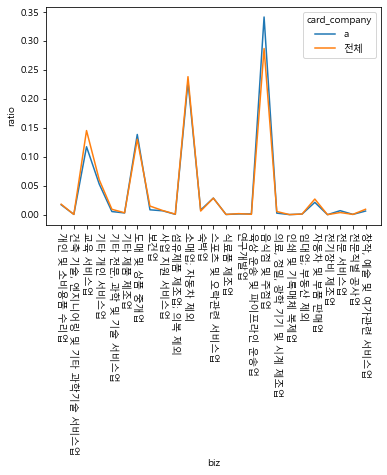

In [25]:
# 전체 카드사평균과 a사 업종구성비율 비교
df1=df.groupby(['biz'])['amount'].sum().to_frame()
df1=df1.reset_index()
df1['ratio']=df1['amount']/df1['amount'].sum()

df2=df[df['card_company']=='a']
df2=df2.groupby(['card_company','biz'])['amount'].sum().to_frame()
df2=df2.reset_index()
df2['ratio']=df2['amount']/df2['amount'].sum()

df3= df2.append(df1)
df3=df3.fillna('전체')

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
plt.xticks(rotation = -90)

sns.lineplot(data=df3, x="biz", y="ratio", 
             hue='card_company')
sns.set(rc={'figure.figsize':(15,8)})

# 카드사별 서비스 제안

<img src = "https://github.com/dureejung/project_2/blob/main/image/a.jpg?raw=true" width="75%" align="left">
<img src = "https://github.com/dureejung/project_2/blob/main/image/h.jpg?raw=true" width="75%" align="left">
<img src = "https://github.com/dureejung/project_2/blob/main/image/b.jpg?raw=true" width="75%" align="left">
<img src = "https://github.com/dureejung/project_2/blob/main/image/f.jpg?raw=true" width="75%" align="left">